## Imports

In [8]:
import numpy as np
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout,Conv2D, Flatten , MaxPooling2D, TimeDistributed
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
import re

# for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
K.clear_session()

## Functions

In [3]:
# extract prefix to group by participant insted of trip
def extract_prefix(filename):
    # split filename on '_' 
    return re.split(r'_', filename)[0]

# create sequences of consecutive intrevales 
def create_sequences(data, labels, filenames, window_size):
    # vars to store the sequences and the respective labels
    sequences = []
    sequence_labels = []
    
    # get the file name to filter by participant
    current_prefix = extract_prefix(filenames[0])
    current_sequence = []
    current_labels = []
    
    # loop all intrevals
    for i in range(len(data)):
        # get current filename
        prefix = extract_prefix(filenames[i])
        
        # if the intreval belongs to diferent participant reset the sequences and vars
        if prefix != current_prefix:
            current_prefix = prefix
            current_sequence = [] 
            current_labels = []

        # add the intrevlal and the label to the current sequence
        current_sequence.append(data[i])
        current_labels.append(labels[i])
        
        # check if the sequence reach the max size and if so, store the sequence and the lable
        if len(current_sequence) == window_size:
            sequences.append(current_sequence.copy()) 
            sequence_labels.append(current_labels[-1]) 
            current_sequence.pop(0)

    return np.array(sequences), np.array(sequence_labels)

## Data Pre-Processing

In [4]:
# get data
file_path_1 = '../pre_process_2/datasets_v2/supervised_1_min.csv'
df_1_min = pd.read_csv(file_path_1, delimiter=',')

# filenames with the "pvt recording"
filenames_to_remove = [
    "fp01_2.edf", "fp01_4.edf", "fp02_1.edf", "fp02_2.edf", "fp02_4.edf",
    "fp03_1.edf", "fp03_2.edf", "fp04_1.edf", "fp05_1.edf", "fp06_1.edf",
    "fp07_1.edf", "fp08_1.edf", "fp09_1.edf", "fp10_1.edf", "fp11_1.edf",
    "fp12_1.edf", "fp13_1.edf", "fp14_1.edf", "fp14_3.edf", "fp15_1.edf",
    "fp16_1.edf", "fp17_1.edf", "fp17_2.edf", "fp17_4.edf", "fp18_1.edf",
    "fp18_2.edf", "fp19_1.edf", "fp19_3.edf", "fp19_4.edf", "fp20_1.edf", 
    "fp20_3.edf"
]

#remove the unwanted instances from the dfs
df_1_min = df_1_min[~df_1_min['Filename'].isin(filenames_to_remove)]

# remove columns with null values
df_1_min = df_1_min[(df_1_min.columns.difference(['HRV_SDANN1','HRV_SDNNI1','HRV_SDANN2','HRV_SDNNI2','HRV_SDANN5','HRV_SDNNI5','HRV_ULF','HRV_VLF'], sort=False))]

# remove missing values
df_1_min = df_1_min.dropna()

# get wanted features for training data
df_features_1_min = df_1_min[(df_1_min.columns.difference(['Interval_Start', 'Interval_End', 'Filename', 'kss_answer'], sort=False))]

# final wanted features
features_1_min = df_features_1_min.columns.to_list()

### Normalization

In [5]:
# Normalize data
scaler = StandardScaler()
X_scaled_1_min = scaler.fit_transform(df_1_min[features_1_min].values)

### Descretrization

In [6]:
# descretize the value of KSS
labels_1_min = (df_1_min['kss_answer'] > 6).astype(int)

### Prepare data to train the model

In [18]:
# get all filenames
filenames_1_min = df_1_min['Filename'].values

# number of intrevlas in sequence
window_size = 4

# create sequences and respective lables
X_sequences_1_min, y_sequences_1_min = create_sequences(X_scaled_1_min, labels_1_min.values, filenames_1_min, window_size)

# Verify shape of sequences
print("Shape of X_sequences of 1 Min :", X_sequences_1_min.shape)
print("Shape of y_sequences of 1 Min:", X_sequences_1_min.shape)

# test and train data split
X_train_1_min, X_test_1_min, y_train_1_min, y_test_1_min = train_test_split(X_sequences_1_min, y_sequences_1_min, test_size=0.20, random_state=42)

print("Shape of X_train_1_min of 1 Min:", X_train_1_min.shape)

Shape of X_sequences of 1 Min : (4289, 4, 27)
Shape of y_sequences of 1 Min: (4289, 4, 27)
Shape of X_train_1_min of 1 Min: (3431, 4, 27)


In [13]:
X_train_1_min.shape

(3431, 4, 27)

### Create LSTM Model

In [ ]:
# reset the model and optimizer state
K.clear_session()

# Definir o modelo
model_cnn_lstm = Sequential([
    # Camada Conv1D para cada janela temporal (sem TimeDistributed)
    tf.keras.layers.Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(X_train_1_min.shape[1], X_train_1_min.shape[2])),

    # MaxPooling1D para reduzir a dimensionalidade
    tf.keras.layers.MaxPooling1D(pool_size=2),

    # Camada LSTM, agora com a entrada das sequências com a dimensão temporal intacta
    LSTM(32, return_sequences=False),  # return_sequences=False já reduz a dimensão para um único vetor de saída

    # Dropout para regularização
    Dropout(0.2),

    # Camada densa
    Dense(16, activation='relu'),
    Dropout(0.2),

    # Camada de saída
    Dense(1, activation='sigmoid')  # Para classificação binária
])

# Compilar o modelo
model_cnn_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

### Train Model

In [38]:
# train models
history_1_min = model_cnn_lstm.fit(X_train_1_min, y_train_1_min, epochs=200, batch_size=32, validation_split=0.2)

Epoch 1/200
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5995 - loss: 0.6746 - val_accuracy: 0.6710 - val_loss: 0.6353
Epoch 2/200
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6474 - loss: 0.6276 - val_accuracy: 0.6681 - val_loss: 0.6112
Epoch 3/200
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6818 - loss: 0.6080 - val_accuracy: 0.6769 - val_loss: 0.5916
Epoch 4/200
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6952 - loss: 0.5837 - val_accuracy: 0.6929 - val_loss: 0.5744
Epoch 5/200
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7155 - loss: 0.5653 - val_accuracy: 0.6943 - val_loss: 0.5646
Epoch 6/200
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7306 - loss: 0.5500 - val_accuracy: 0.7001 - val_loss: 0.5608
Epoch 7/200
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7422 - loss: 0.5316 - val_accuracy: 0.7016 - val_loss: 0.5549
Epoch 8/200
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7588 - loss: 0.5149 - val_accuracy: 0.7016 - v

### Evaluation and Visualization

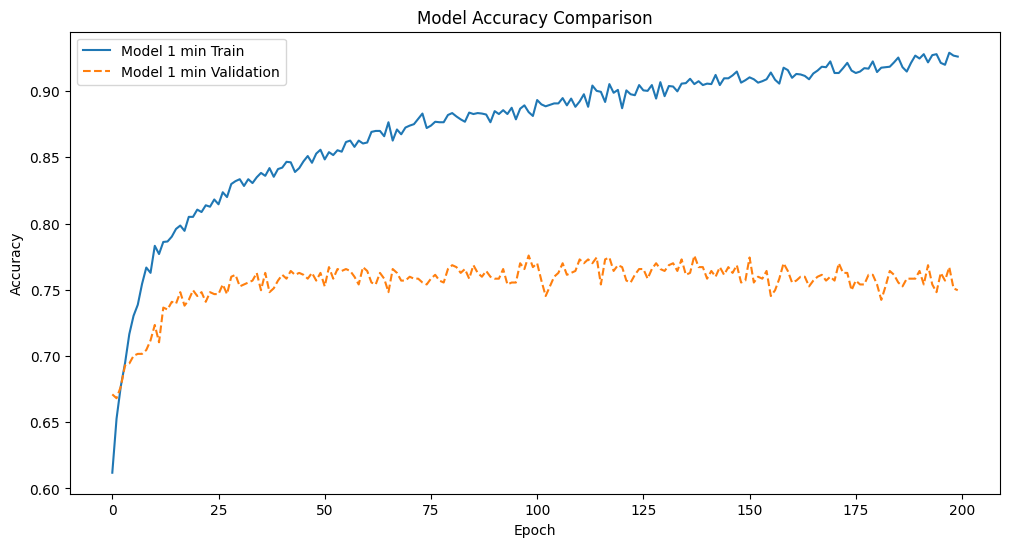

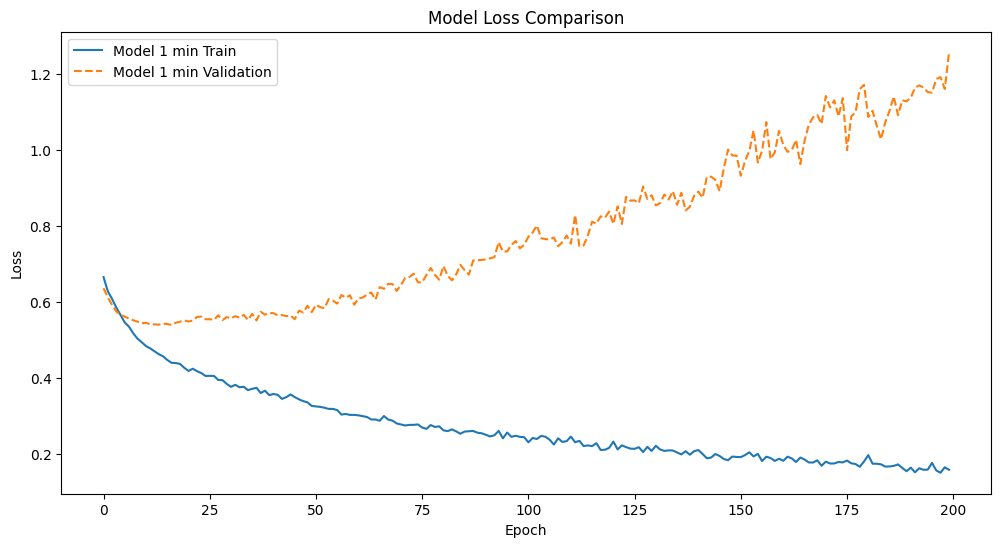

In [39]:
# plot accuracy for all models
plt.figure(figsize=(12, 6))

plt.plot(history_1_min.history['accuracy'], label=f'Model 1 min Train')
plt.plot(history_1_min.history['val_accuracy'], label=f'Model 1 min Validation', linestyle='--')
plt.title('Model Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.show()

# plot loss for all models
plt.figure(figsize=(12, 6))
plt.plot(history_1_min.history['loss'], label=f'Model 1 min Train')
plt.plot(history_1_min.history['val_loss'], label=f'Model 1 min Validation', linestyle='--')
plt.title('Model Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.show()

## Models Predictions

### ROC Curve

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Final Test Predictions Results for ['Model 1 min']:
  Accuracy: 0.781
  Precision: 0.763
  Recall: 0.747
  F1 Score: 0.755


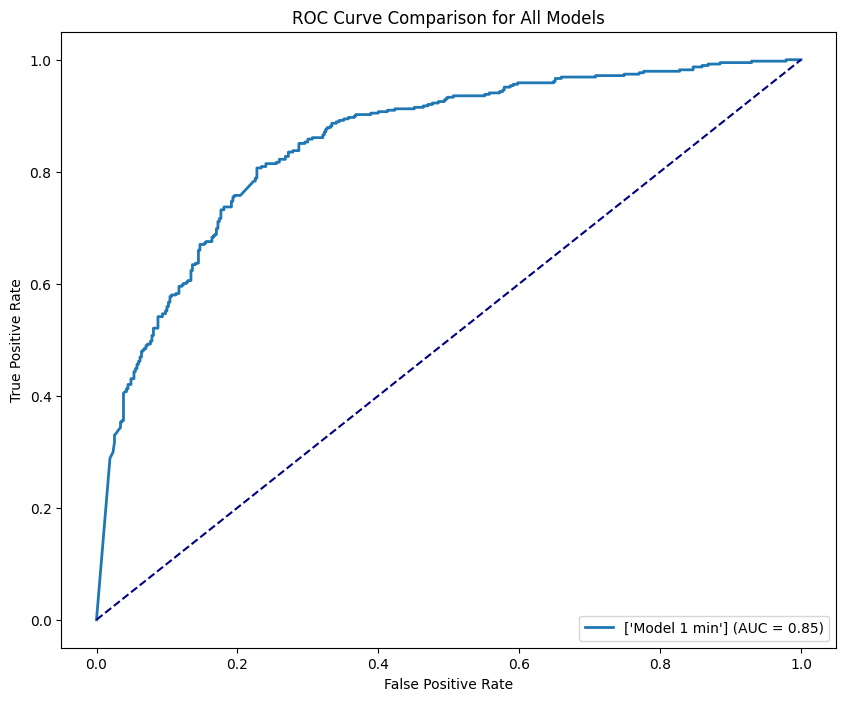

In [40]:
# module name
name = ['Model 1 min']

# store results
all_metrics = []

# ROC plot setup
plt.figure(figsize=(10, 8))


# make predictions
y_pred = model_cnn_lstm.predict(X_test_1_min)
y_pred_binary = (y_pred > 0.5).astype(int).reshape(-1)  # threshold and reshape to binary

# evaluation metrics
accuracy = accuracy_score(y_test_1_min, y_pred_binary)
precision = precision_score(y_test_1_min, y_pred_binary)
recall = recall_score(y_test_1_min, y_pred_binary)
f1 = f1_score(y_test_1_min, y_pred_binary)
    
# append metrics results
all_metrics.append((name, accuracy, precision, recall, f1))
    
# print results for the model
print(f"Final Test Predictions Results for {name}:")
print(f'  Accuracy: {accuracy:.3f}')
print(f'  Precision: {precision:.3f}')
print(f'  Recall: {recall:.3f}')
print(f'  F1 Score: {f1:.3f}')
    
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test_1_min, y_pred)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.2f})')

# plot all ROC curves together
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison for All Models')
plt.legend(loc="lower right")
plt.show()

### Confusion Matrix

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 536us/step


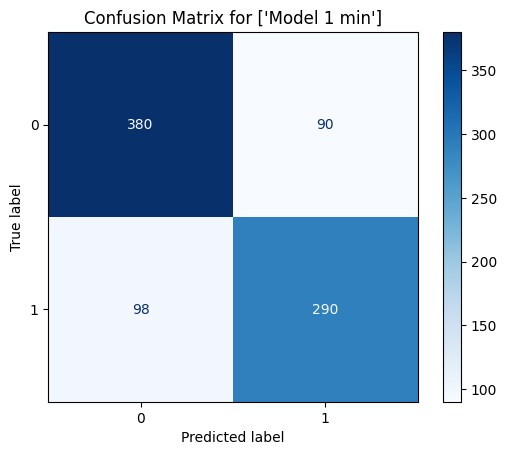

In [41]:
# CM
y_pred_binary = (model_cnn_lstm.predict(X_test_1_min) > 0.5).astype(int).reshape(-1)
cm = confusion_matrix(y_test_1_min, y_pred_binary)
    
# plot CM
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title(f'Confusion Matrix for {name}')
plt.show()